In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plotting configuration
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

## Loading data & Overview

In [2]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
train.head(10)

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False
5,0,23,37,12,5,94,0.010938,-0.238878,0.021548,-0.322706,...,-0.062753,-0.004552,-0.097196,0.012677,-0.331521,0.032527,0.665084,0.008400,-0.037627,False
6,0,45,52,18,7,121,0.010602,-0.139011,-0.015338,-0.242468,...,-0.273181,-0.003767,0.296727,0.022470,0.158390,-0.005110,-0.219619,0.006428,-0.189815,False
7,0,59,57,20,8,143,0.001608,0.351362,-0.040863,-0.274854,...,0.008281,0.043372,-0.085970,-0.012924,-0.256353,-0.034321,-0.348341,0.011839,-0.811403,False
8,0,60,46,16,7,108,0.022012,NaN,-0.018519,NaN,...,NaN,0.019781,NaN,-0.028816,NaN,0.000000,NaN,0.007527,-0.333896,False


In [3]:
train.info()

<class 'pandas.DataFrame'>
RangeIndex: 418595 entries, 0 to 418594
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6        34388

Note: DATE is just grouping key
- No continuity (DATE 10 is not after DATE 9), we only know that within each row (each date) we have the last 20 days of return data
- Time structure only exists inside each feature vector, not across rows 
- The problem is cross-sectional per (DATE, STOCK), not a classical time series with continuous timeline

-> Avoid using DATE as a numeric time index or computing lag/rolling features across DATE.

-> Use DATE only for cross‑sectional grouping (e.g., percentile ranks within each DATE, group CV to avoid leakage between same DATE in train/val).

In [4]:
# Define feature groups
ret_cols = [f'RET_{i}' for i in range(1, 21)]
vol_cols = [f'VOLUME_{i}' for i in range(1, 21)]
cat_cols = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']

print(f"\nReturn features: {len(ret_cols)}")
print(f"Volume features: {len(vol_cols)}")
print(f"Categorical features: {len(cat_cols)}")
print(f"Target: RET (binary)")



Return features: 20
Volume features: 20
Categorical features: 6
Target: RET (binary)


In [5]:
# Target balance analysis
print("\n" + "-"*60)
print("TARGET BALANCE ANALYSIS")
print("-"*60)
target_counts = train['RET'].value_counts()
target_pct = train['RET'].value_counts(normalize=True) * 100

print(f"False: {target_counts[False]:,} ({target_pct[False]:.2f}%)")
print(f"True:  {target_counts[True]:,} ({target_pct[True]:.2f}%)")
print(f"Balance ratio: {target_counts.min() / target_counts.max():.3f}")


------------------------------------------------------------
TARGET BALANCE ANALYSIS
------------------------------------------------------------
False: 209,749 (50.11%)
True:  208,846 (49.89%)
Balance ratio: 0.996


Dataset is balanced -> No resampling needed, no need to handle imbalanced data issues

I start with investigating the structure of the data. In particular, I look at missing values, the balance of the dataset and potential correlation between features of the dataset.

## Missing Data Analysis

In [6]:
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Percentage', ascending=False)

missing_df = missing_df[missing_df['Missing_Count'] > 0]

print("Missing Data Summary:")
print(missing_df.head(25).to_string())

Missing Data Summary:
           Missing_Count  Missing_Percentage
VOLUME_6           74714               17.85
VOLUME_5           74693               17.84
VOLUME_8           73898               17.65
VOLUME_7           73853               17.64
VOLUME_10          73305               17.51
VOLUME_9           73298               17.51
VOLUME_11          72025               17.21
VOLUME_4           70997               16.96
VOLUME_20          67857               16.21
VOLUME_3           67819               16.20
VOLUME_18          67586               16.15
VOLUME_19          67329               16.08
VOLUME_16          67262               16.07
VOLUME_15          66373               15.86
VOLUME_2           66386               15.86
VOLUME_1           65025               15.53
VOLUME_12          62523               14.94
VOLUME_17          62314               14.89
VOLUME_14          60929               14.56
VOLUME_13          59008               14.10
RET_20              5341         

RET features: ~0.5-0.6% missing. VOLUME features: ~15-18% missing. VOLUME_6 onwards show higher missingness.

Why so many missing values: Maybe one of the reason is beacause of the relative volumes are computed using the median and the way the median function is implemented in python could cause the NaN values: if we compute the relative volume over a period of 10 days and there is one NaN value at day D, the relative volume will show NaN values from day D to day D+10.

The NaN values in the RET and VOLUME columns can come from the nature of the stock market data: The market closes on some days (weekends, public holidays, etc.)

In [7]:
ret_early = [f'RET_{i}' for i in range(1, 6)]
all_ret_missing = train[ret_early].isnull().all(axis=1)
print(f"\nRows with ALL of RET_1 to RET_5 missing: {all_ret_missing.sum():,}")
print(f"Percentage: {all_ret_missing.sum() / len(train) * 100:.3f}%")


Rows with ALL of RET_1 to RET_5 missing: 2,256
Percentage: 0.539%


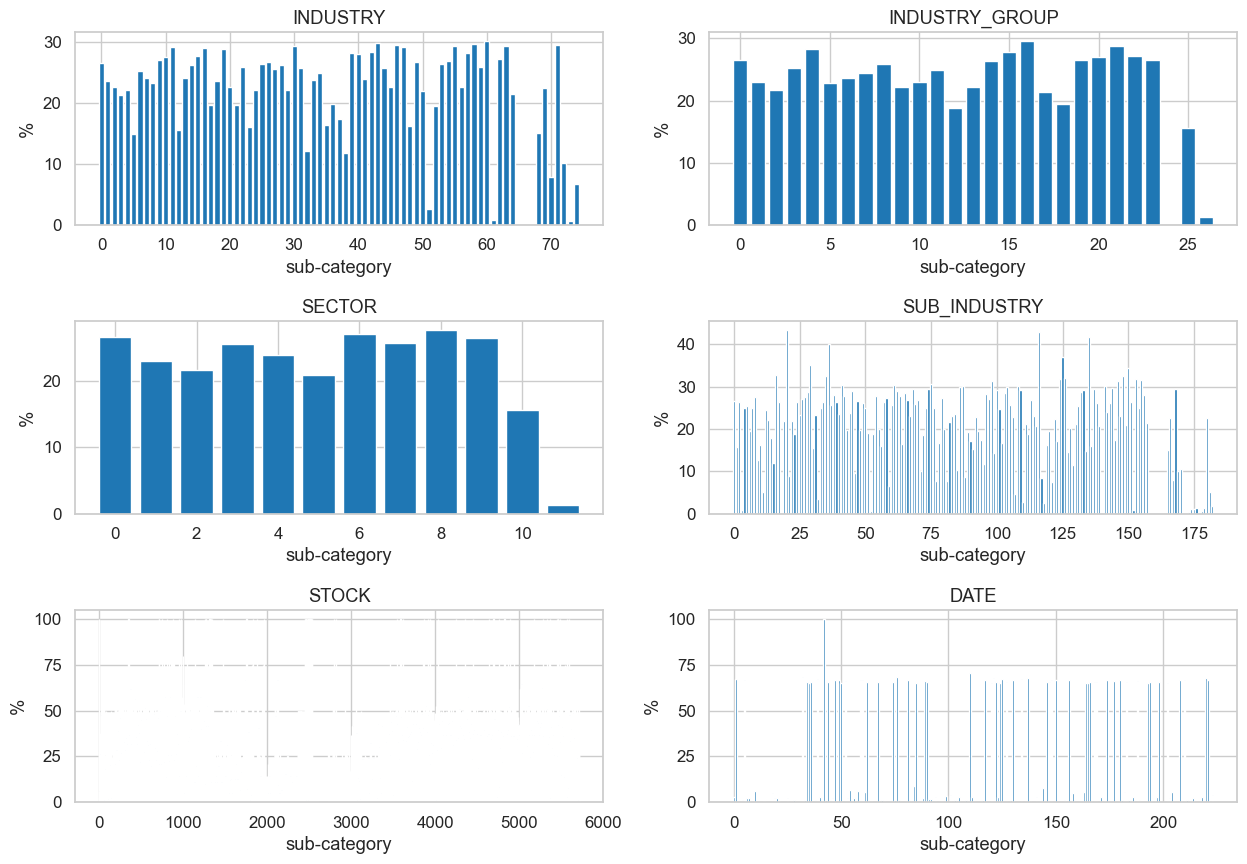

In [8]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i,category in enumerate(['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'STOCK', 'DATE']): 
    plt.subplot(3,2,i+1)
    plt.title(category)
    plt.bar(train[category].sort_values().unique(),
            [(train[train[category]==sub_category].isna().sum(axis=1)>0).sum()/len(train[train[category]==sub_category])*100 for sub_category in train[category].sort_values().unique()])
    plt.xlabel('sub-category')
    plt.ylabel('%')
plt.show()

The plots show the distribution of NaN values per sub-categorie in %. We can see a "fairly" even distribution of NaN values for some categorical variable sectors, whereas #NaN values for the other categorical variables seems less equally spread. It might be interesting to see if there are rows that predominantely consist of NaN values (for the descriptive variables RET and VOLUME). If so, we can drop them since these columns do not add any value in understanding the underlying structure. During this investigation, I noticed the following:

In [9]:
# Check if there exist a row containing mainly NaN values
ret_features = [f'RET_{day}' for day in range(1,6)]
#features += [f'VOLUME_{day}' for day in range(1,21)] # No need to consider VOLUME since it either is there or not
ret_to_drop = train[(train[ret_features].isna().sum(axis=1)/(train[ret_features].shape[1]) >= 1)][ret_features]
ret_to_drop

,RET_1,RET_2,RET_3,RET_4,RET_5
ID,,,,,
2237,NaN,NaN,NaN,NaN,NaN
19916,NaN,NaN,NaN,NaN,NaN
20232,NaN,NaN,NaN,NaN,NaN
27739,NaN,NaN,NaN,NaN,NaN
28578,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
401583,NaN,NaN,NaN,NaN,NaN
401584,NaN,NaN,NaN,NaN,NaN
401585,NaN,NaN,NaN,NaN,NaN


Given no observed returns, there is no volume observed -> only delete those observations where no return has been observed over the past 5 days. I chose a 5 day window since they are the most important signals, and I am using use the observations of the past 5 days in my analysis and prediction.

These rows have no recent return history -> uninformative

-> Drop these rows -> Remaining NaNs filled with mean/median

In [10]:
train_clean = train[~all_ret_missing].copy()
print(f"\nBefore: {len(train):,} rows")
print(f"After dropping: {len(train_clean):,} rows ({len(train) - len(train_clean):,} dropped)")


Before: 418,595 rows
After dropping: 416,339 rows (2,256 dropped)


In [11]:
train.drop(index=ret_to_drop.index, inplace=True)
(train.isna().sum()/len(train)*100)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.024739
VOLUME_1          15.076416
RET_2              0.050199
VOLUME_2          15.403313
RET_3              0.060287
VOLUME_3          15.747504
RET_4              0.069174
VOLUME_4          16.510824
RET_5              0.078782
VOLUME_5          17.398562
RET_6              0.082385
VOLUME_6          17.403606
RET_7              0.080944
VOLUME_7          17.196804
RET_8              0.089590
VOLUME_8          17.207612
RET_9              0.103762
VOLUME_9          17.063499
RET_10             0.106163
VOLUME_10         17.065180
RET_11             0.170294
VOLUME_11         16.757738
RET_12             0.225297
VOLUME_12         14.475464
RET_13             0.266850
VOLUME_13         13.631200
RET_14             0.519529
VOLUME_14         14.092602
RET_15             0.657877
VOLUME_15         15

After dropping, missing values number in RET are low, but there's still significant NaNs in VOLUME. Let's examine that now

In [12]:
volume = pd.DataFrame(columns=['day', 'ret_mean', 'ret_median', 'ret_std', 'vol_mean', 'vol_median', 'vol_std'])
for day in range(1,6): # examine 5 days of volume and return features
    volume.loc[day] =[day, train[f'RET_{day}'].mean(), train[f'RET_{day}'].median(), train[f'RET_{day}'].std(), 
                      train[f'VOLUME_{day}'].mean(), train[f'VOLUME_{day}'].median(), train[f'VOLUME_{day}'].std()]
volume

,day,ret_mean,ret_median,ret_std,vol_mean,vol_median,vol_std
1,1.0,0.001383,0.000637,0.031311,-0.071502,-0.282609,3.038658
2,2.0,0.000973,0.000401,0.030987,-0.075230,-0.278437,2.635549
3,3.0,0.002153,0.000909,0.031332,-0.097235,-0.278277,2.490831
4,4.0,-0.000679,-0.000495,0.031224,-0.088976,-0.275435,1.730786
5,5.0,0.000358,0.000000,0.031886,-0.092163,-0.281238,1.848977


The mean of relative volume for each trading day is ~0, and the std isn't too large. The median is quite consistent across days. Indeed, we can have a look at the box plots.

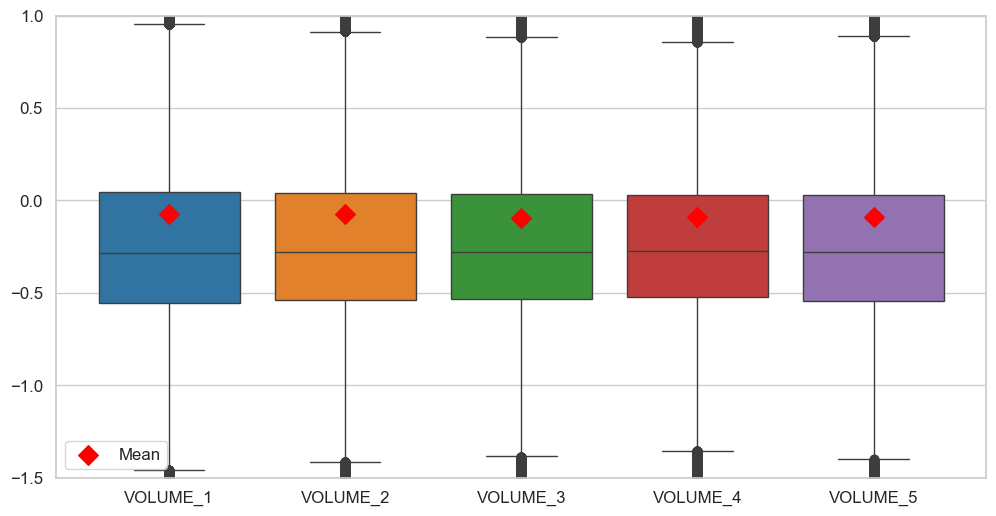

In [13]:
vol_data = train[[f'VOLUME_{day}' for day in range(1,6)]]
sns.boxplot(data=vol_data) 
plt.ylim((-1.5,1))

means = [vol_data[col].mean() for col in vol_data.columns]
positions = range(len(means))
plt.scatter(positions, means, color='red', marker='D', s=100, zorder=3, label='Mean')

plt.legend()
plt.show()

A bulk of VOLUME data sits in the negative range around -0.5 to 0. The median is around -0.3/0.4. There are quite a few outliers that skew the mean toward the upper end. In fact, in  financial data, extreme values (high volume days) are common but not typical --> Use imputation with median to avoid bias

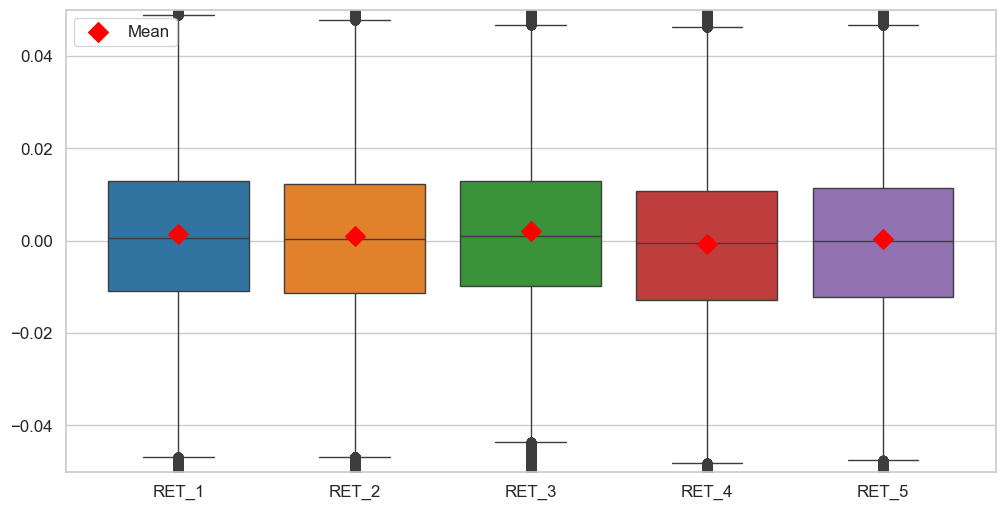

In [14]:
ret_data = train[[f'RET_{day}' for day in range(1,6)]]
sns.boxplot(data=ret_data)
plt.ylim((-0.05,0.05))

means = [ret_data[col].mean() for col in ret_data.columns]
positions = range(len(means))
plt.scatter(positions, means, color='red', marker='D', s=100, zorder=3, label='Mean')

plt.legend()
plt.show()

For RET, median and mean almost coincide. For convenience I chose median imputation.

## Distribution Analysis

In [15]:
ret_stats = train_clean[ret_cols].describe().T
ret_stats['skewness'] = train_clean[ret_cols].skew()
ret_stats['kurtosis'] = train_clean[ret_cols].kurtosis()

print("RETURNS: Summary Statistics (first 5 lags)")
print("-"*60)
print(ret_stats[['mean', 'std', 'skewness', 'kurtosis']].head().round(4))


RETURNS: Summary Statistics (first 5 lags)
------------------------------------------------------------
         mean     std  skewness  kurtosis
RET_1  0.0014  0.0313    1.9719   78.1434
RET_2  0.0010  0.0310    1.2574   49.5551
RET_3  0.0022  0.0313    3.5400  276.9720
RET_4 -0.0007  0.0312    1.8370  118.0640
RET_5  0.0004  0.0319    2.1161   76.9819


Mean RET close to 0 -> roughly centered

Positive skewness and very high kurtosis -> heavy righ tail, fat tails vs Gaussian -> should not use models that assume normality (linear regression w homoscedascity assumptions)

In [16]:
vol_stats = train_clean[vol_cols].describe().T
vol_stats['skewness'] = train_clean[vol_cols].skew()
vol_stats['kurtosis'] = train_clean[vol_cols].kurtosis()
print(vol_stats[['mean', 'std', 'skewness', 'kurtosis']].head().round(4))

            mean     std  skewness    kurtosis
VOLUME_1 -0.0715  3.0387  230.0347  82279.9627
VOLUME_2 -0.0752  2.6355  137.4494  27987.9269
VOLUME_3 -0.0972  2.4908  205.1564  66619.4060
VOLUME_4 -0.0890  1.7308   81.6641  15114.3938
VOLUME_5 -0.0922  1.8490   82.7749  14587.5616


VOLUME is extremely right-skewed with massive outliers (occasional volume spike)

-> prioritize rank transforming then log transforming

## Stationarity Tests

Because dates are anonymized and each row contains a short 20‑day window for a different stock–date pair, we do not have long, ordered time series per stock (each row of 20 lags is too short, and we cannot concatenate across rows/dates). Classical stationarity tests over time (ADF/KPSS) are therefore not applicable. Instead, I evaluate dependence via cross-sectional correlation between lagged residual returns/volumes and the target.

Stationary is required for time series regressive model but not a problem for tree-based models. I initially made the mistake of checking stationarity of RET and VOLUME across DATEs, but as DATE is just a grouping key without any temporal order, the analysis is invalid.



## Correlation

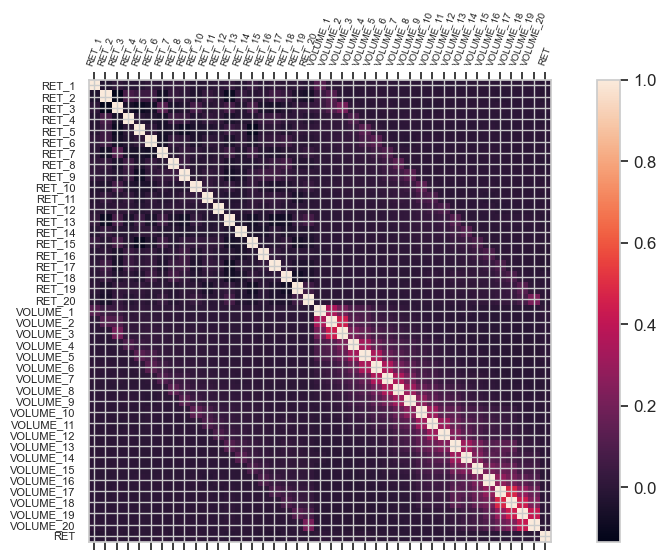

In [ ]:
features = [f'RET_{day}' for day in range(1,21)]
features += [f'VOLUME_{day}' for day in range(1,21)]
features += ['RET']

corr = train[features].corr()

plt.matshow(corr, fignum=0)  
plt.xticks(range(corr.shape[1]), corr.columns, rotation=70, fontsize=7)
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=8)
plt.colorbar()
plt.show()

Pairwise correlation seems low. 

There are local bright spots among neighboring VOLUME_i and weaker ones among neighboring RET_i
-> Expected, as adjacent lags of the same quantity should be somehow correlated

## Correlation with target
First, I check return autocorrelation

In [ ]:
y = train["RET"].astype(float) 
for lag in range(1, 21):
    x = train[f"RET_{lag}"]
    mask = x.notna() & y.notna()
    if mask.sum() > 1:
        corr, pval = stats.spearmanr(x[mask], y[mask]) # Spearman correlation
        print(f"Lag {lag}: corr={corr:.4f}, p={pval:.2e}")
    else:
        print(f"Lag {lag}: not enough data")


Lag 1: corr=-0.0168, p=1.95e-27
Lag 2: corr=-0.0069, p=9.54e-06
Lag 3: corr=0.0055, p=4.36e-04
Lag 4: corr=-0.0029, p=6.05e-02
Lag 5: corr=-0.0017, p=2.82e-01
Lag 6: corr=0.0009, p=5.74e-01
Lag 7: corr=0.0044, p=4.23e-03
Lag 8: corr=-0.0032, p=3.89e-02
Lag 9: corr=-0.0012, p=4.32e-01
Lag 10: corr=0.0099, p=1.75e-10
Lag 11: corr=-0.0014, p=3.84e-01
Lag 12: corr=-0.0015, p=3.30e-01
Lag 13: corr=-0.0082, p=1.39e-07
Lag 14: corr=0.0032, p=3.84e-02
Lag 15: corr=-0.0006, p=7.16e-01
Lag 16: corr=-0.0089, p=8.81e-09
Lag 17: corr=-0.0058, p=1.83e-04
Lag 18: corr=0.0095, p=9.41e-10
Lag 19: corr=0.0015, p=3.37e-01
Lag 20: corr=-0.0016, p=3.04e-01


Past residual returns have a non-0 but small predictive power for the next day signs.

The strongest effect is the negative autocorr at lag 1 -> consistent w short term mean reversion. 

There are small positive signals around lags 10 and 18 (indicatting weak medium-term momentum effect) -> consistent w the model ranking RET10 and RET18 among the most important features.

Here we can extend the autocorrelation analysis to compute lag 1 correlation conditional on categorical variables like SECTOR given that a lot of variability can be attributed to them as analyzed below in variance decomposition.

In [46]:
def corr_by_group(df, group_col, lag_col='RET_1'):
    rows = []
    for g, sub in df.groupby(group_col):
        x = sub[lag_col]
        y = sub['RET'].astype(float)
        m = x.notna() & y.notna()
        if m.sum() > 200:  # enough data
            c, p = stats.spearmanr(x[m], y[m])
            rows.append({'group': g, 'corr': c, 'pval': p, 'n': m.sum()})
    return pd.DataFrame(rows).sort_values('corr')

sector_corr = corr_by_group(train, 'SECTOR', lag_col='RET_1')
industry_corr = corr_by_group(train, 'INDUSTRY', lag_col='RET_1')
industry_group_corr = corr_by_group(train, 'INDUSTRY', lag_col='RET_1')
sub_industry_corr = corr_by_group(train, 'SUB_INDUSTRY', lag_col='RET_1')


In [32]:
sector_corr

,group,corr,pval,n
7,7,-0.044927,2.726612e-40,87389
5,5,-0.028488,1.869504e-04,17194
2,2,-0.028017,1.188053e-04,18865
3,3,-0.019317,5.680744e-06,55182
8,8,-0.013504,3.394167e-04,70403
10,10,-0.013320,1.257524e-01,13213
0,0,-0.006713,5.955887e-01,6254
4,4,-0.005881,1.393829e-01,63166
6,6,-0.003841,3.684425e-01,54819
9,9,0.008709,5.176519e-01,5521


Some sectors show stronger correlation than the global average (0.0168). Some show negative while others have positive correlation -> This justifies using sector-relative features

In [43]:
industry_corr

,group,corr,pval,n
50,51,-0.150693,7.235542e-04,500
29,30,-0.082736,7.566810e-03,1041
51,52,-0.073817,4.494228e-19,14578
67,71,-0.064608,1.805785e-02,1339
46,47,-0.059590,1.841937e-08,8901
...,...,...,...,...
37,38,0.026432,3.185577e-01,1426
68,72,0.027254,3.895181e-01,999
22,23,0.034513,2.762751e-01,997
63,64,0.053476,1.663321e-02,2005


In [47]:
industry_group_corr

,group,corr,pval,n
50,51,-0.150693,7.235542e-04,500
29,30,-0.082736,7.566810e-03,1041
51,52,-0.073817,4.494228e-19,14578
67,71,-0.064608,1.805785e-02,1339
46,47,-0.059590,1.841937e-08,8901
...,...,...,...,...
37,38,0.026432,3.185577e-01,1426
68,72,0.027254,3.895181e-01,999
22,23,0.034513,2.762751e-01,997
63,64,0.053476,1.663321e-02,2005


In [48]:
sub_industry_corr

,group,corr,pval,n
11,11,-0.175960,1.910350e-04,445
108,118,-0.150693,7.235542e-04,500
67,75,-0.134648,8.944999e-03,376
80,88,-0.092469,6.433018e-02,401
112,122,-0.089001,3.174662e-15,7818
...,...,...,...,...
156,177,0.064130,1.534199e-01,497
102,110,0.072736,1.285304e-01,438
6,6,0.077577,1.158968e-03,1751
140,152,0.087578,1.762904e-01,240


Overall we have remarkably stronger correlation conditional on industry, industry_group, and sub_industry at least for lag 1 return and the target return.

--> Should focus on sector, industry-relative features

Then I look at volume dependency

In [52]:
y = train["RET"].astype(float) 
for lag in range(1, 21):
    x = train[f"VOLUME_{lag}"]
    mask = x.notna() & y.notna()
    if mask.sum() > 1:
        corr, pval = stats.spearmanr(x[mask], y[mask]) # Spearman correlation
        print(f"Lag {lag}: corr={corr:.4f}, p={pval:.2e}")
    else:
        print(f"Lag {lag}: not enough data")


Lag 1: corr=0.0201, p=8.25e-33
Lag 2: corr=0.0065, p=1.08e-04
Lag 3: corr=0.0083, p=8.50e-07
Lag 4: corr=0.0086, p=4.23e-07
Lag 5: corr=0.0113, p=3.29e-11
Lag 6: corr=0.0071, p=3.02e-05
Lag 7: corr=0.0022, p=1.98e-01
Lag 8: corr=0.0051, p=2.60e-03
Lag 9: corr=0.0021, p=2.08e-01
Lag 10: corr=0.0061, p=3.05e-04
Lag 11: corr=0.0111, p=6.27e-11
Lag 12: corr=0.0112, p=2.58e-11
Lag 13: corr=0.0064, p=1.24e-04
Lag 14: corr=0.0074, p=1.03e-05
Lag 15: corr=0.0037, p=2.88e-02
Lag 16: corr=0.0050, p=2.90e-03
Lag 17: corr=0.0039, p=2.07e-02
Lag 18: corr=0.0142, p=5.11e-17
Lag 19: corr=0.0102, p=1.69e-09
Lag 20: corr=0.0051, p=2.41e-03


VOLUME_1, 5, 11, 12, 18, 19 have relatively stronger correlation with target --> Use volume features as well

In [59]:
sector_vol_corr = corr_by_group(train, 'SECTOR', lag_col='VOLUME_1')
industry_vol_corr = corr_by_group(train, 'INDUSTRY', lag_col='VOLUME_1')
industry_group_vol_corr = corr_by_group(train, 'INDUSTRY_GROUP', lag_col='VOLUME_1')
sub_industry_vol_corr = corr_by_group(train, 'SUB_INDUSTRY', lag_col='VOLUME_1')

In [60]:
sector_vol_corr

,group,corr,pval,n
1,1,0.004445,5.475690e-01,18306
10,10,0.008406,3.570177e-01,12007
7,7,0.010038,6.418592e-03,73728
2,2,0.011737,1.322476e-01,16451
4,4,0.019984,3.414203e-06,53997
3,3,0.020028,1.498866e-05,46709
9,9,0.020786,1.580468e-01,4614
11,11,0.023074,2.037957e-01,3035
8,8,0.024608,2.485696e-09,58693
6,6,0.027724,2.984622e-09,45774


In [ ]:
industry_vol_corr

,group,corr,pval,n
67,71,-0.041455,0.168300,1106
60,61,-0.038375,0.554103,240
22,23,-0.017562,0.597762,905
4,4,-0.013925,0.687115,839
6,6,-0.013664,0.373737,4240
...,...,...,...,...
34,35,0.053167,0.016805,2022
7,7,0.054514,0.046350,1336
38,39,0.058587,0.009569,1955
35,36,0.062909,0.000003,5446


Volume 1 corr with targer by industry is relatively significant.

In [61]:
industry_group_vol_corr

,group,corr,pval,n
19,19,-0.008718,2.755585e-01,15643
6,6,-0.004353,7.962117e-01,3523
5,5,0.001506,9.013615e-01,6775
16,16,0.002300,6.810289e-01,31957
1,1,0.004445,5.475690e-01,18306
7,7,0.007551,4.153291e-01,11639
24,25,0.008406,3.570177e-01,12007
2,2,0.011737,1.322476e-01,16451
18,18,0.016517,6.109092e-02,12858
11,11,0.017373,3.196876e-01,3283


In [62]:
sub_industry_vol_corr

,group,corr,pval,n
72,80,-0.078571,0.032711,739
102,110,-0.066743,0.166129,432
16,16,-0.063692,0.326847,239
115,125,-0.061037,0.219170,407
155,176,-0.058613,0.305993,307
...,...,...,...,...
67,75,0.098719,0.082679,310
82,90,0.107380,0.014199,521
119,129,0.108873,0.083935,253
21,23,0.132401,0.007191,411


## Variance Decomposition

In [20]:
def compute_icc(data, target_col, group_col):
    """Compute Intra-Class Correlation (ICC)"""
    group_means = data.groupby(group_col)[target_col].mean()
    overall_mean = data[target_col].mean()
    group_sizes = data.groupby(group_col).size()

    var_between = ((group_means - overall_mean) ** 2 * group_sizes).sum() / (len(group_means) - 1)
    var_within = data.groupby(group_col)[target_col].var().mean()
    icc = var_between / (var_between + var_within)

    return icc * 100

icc_results = []
for cat in ['SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']:
    icc = compute_icc(train_clean, 'RET_numeric', cat)
    print(f"{cat:20s}: {icc:.2f}%")
    icc_results.append(icc)

avg_icc = np.mean(icc_results)
print(f"\nAverage ICC: {avg_icc:.2f}%")


SECTOR              : 90.77%
INDUSTRY            : 85.26%
INDUSTRY_GROUP      : 89.81%
SUB_INDUSTRY        : 78.98%

Average ICC: 86.20%


90% of variability in RET is explained by different means across sector, only 10% of residual variation inside sectors

-> Group identifiers like sector, industry, etc. are very informative features for RET

-> Can try sector/industry-level aggregated features (sector momentum, sector RSI, sector ADL)

Good news: 
- Balanced target: 50/50 split
- Reasonable size: 418k train samples over 224 days (~1,870 stocks/day)
- Signal exists: RET_1, VOLUME_1, and some other lags, stronger correlation are seen categorized by sector/industry

Issues:
- High volume missing: ~18% missing in VOLUME features (74k/418k)
- Date encoding: Dates are integers (0-223), not timestamps—fine for splitting